In [3]:
!pip install tensorflow numpy pandas matplotlib scikit-learn


## Step 1: Load the Dataset

In [4]:
import pandas as pd

# Load the dataset
file_path = '/content/GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv'
data = pd.read_csv(file_path)

# View the first few rows to understand its structure
print(data.head())


           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland


## Step 2: Handle Missing Values

In [5]:
# Interpolate missing values
data['AverageTemperature'] = data['AverageTemperature'].interpolate(method='linear', limit_direction='forward')
data['AverageTemperatureUncertainty'] = data['AverageTemperatureUncertainty'].interpolate(method='linear', limit_direction='forward')

# Verify if the missing values are handled
print(data.isnull().sum())


dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          1
dtype: int64


## Step 3: Extract and Standardize Date Features

In [6]:
# Convert the date column and extract features
data['dt'] = pd.to_datetime(data['dt'])
data['Year'] = data['dt'].dt.year
data['Month'] = data['dt'].dt.month
data['Season'] = data['Month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else 'Autumn'
)

# Check the changes
print(data[['dt', 'Year', 'Month', 'Season']].head())


          dt  Year  Month  Season
0 1743-11-01  1743     11  Autumn
1 1743-12-01  1743     12  Winter
2 1744-01-01  1744      1  Winter
3 1744-02-01  1744      2  Winter
4 1744-03-01  1744      3  Spring


## Step 4: Feature Engineering - Rolling and Yearly Averages

In [7]:
# Add rolling averages
data['RollingAvg_12M'] = data.groupby('Country')['AverageTemperature'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Add yearly averages
data['YearlyAvgTemp'] = data.groupby(['Country', 'Year'])['AverageTemperature'].transform('mean')

# Check feature additions
print(data[['Country', 'Year', 'RollingAvg_12M', 'YearlyAvgTemp']].head())


  Country  Year  RollingAvg_12M  YearlyAvgTemp
0   Åland  1743          4.3840         4.0986
1   Åland  1743          4.0986         4.0986
2   Åland  1744          3.8132         6.2604
3   Åland  1744          3.5278         6.2604
4   Åland  1744          3.2424         6.2604


## Step 5: Calculate Temperature Anomalies

In [8]:
# Calculate baseline temperature (1850-1900 average)
baseline_data = data[(data['Year'] >= 1850) & (data['Year'] <= 1900)]
baseline_avg = baseline_data.groupby('Country')['AverageTemperature'].mean().reset_index()
baseline_avg.rename(columns={'AverageTemperature': 'BaselineTemp'}, inplace=True)

# Merge with main data and calculate anomaly
data = data.merge(baseline_avg, on='Country', how='left')
data['TempAnomaly'] = data['AverageTemperature'] - data['BaselineTemp']

# Check for temperature anomaly
print(data[['Country', 'AverageTemperature', 'BaselineTemp', 'TempAnomaly']].head())


  Country  AverageTemperature  BaselineTemp  TempAnomaly
0   Åland              4.3840      4.943289    -0.559289
1   Åland              3.8132      4.943289    -1.130089
2   Åland              3.2424      4.943289    -1.700889
3   Åland              2.6716      4.943289    -2.271689
4   Åland              2.1008      4.943289    -2.842489


##Step 6: Flag Sparse Data

In [9]:
# Flag countries with sparse data (less than 50 records)
country_data_counts = data.groupby('Country')['AverageTemperature'].count()
sparse_countries = country_data_counts[country_data_counts < 50].index
data['SparseDataFlag'] = data['Country'].isin(sparse_countries)

# Check sparse data flag
print(data[['Country', 'SparseDataFlag']].drop_duplicates().head())


           Country  SparseDataFlag
0            Åland           False
3239   Afghanistan           False
5345        Africa           False
7310       Albania           False
10549      Algeria           False


##  Global Temperature Trends Over Centuries

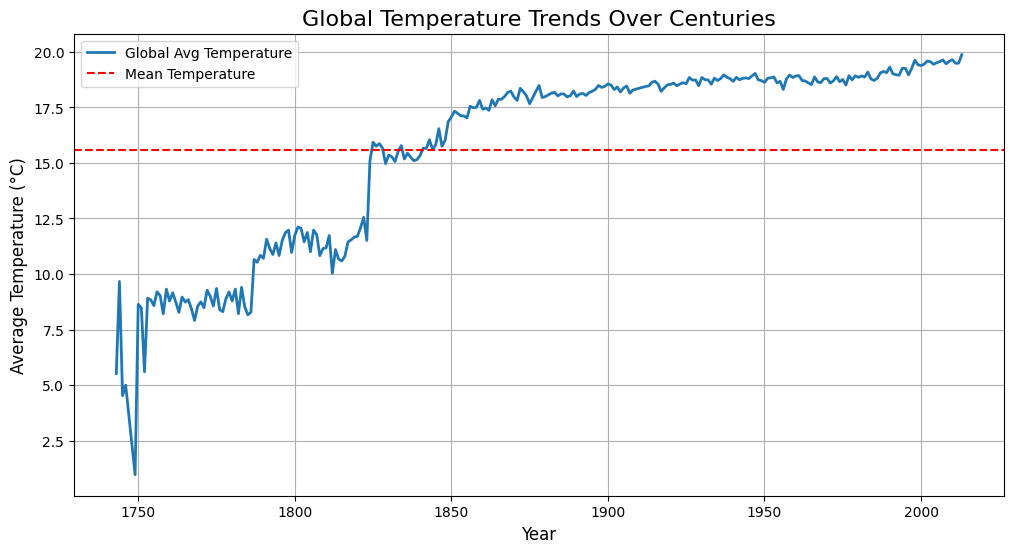

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Global temperature trends over centuries
global_trends = data.groupby('Year')['AverageTemperature'].mean().reset_index()

# Plot: Global temperature trends over centuries
plt.figure(figsize=(12, 6))
plt.plot(global_trends['Year'], global_trends['AverageTemperature'], label='Global Avg Temperature', linewidth=2)
plt.axhline(global_trends['AverageTemperature'].mean(), color='red', linestyle='--', label='Mean Temperature')
plt.title('Global Temperature Trends Over Centuries', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

A steady rise in global average temperatures is noticeable, with a sharp increase in the 20th century.

##  Country-Wise Comparisons

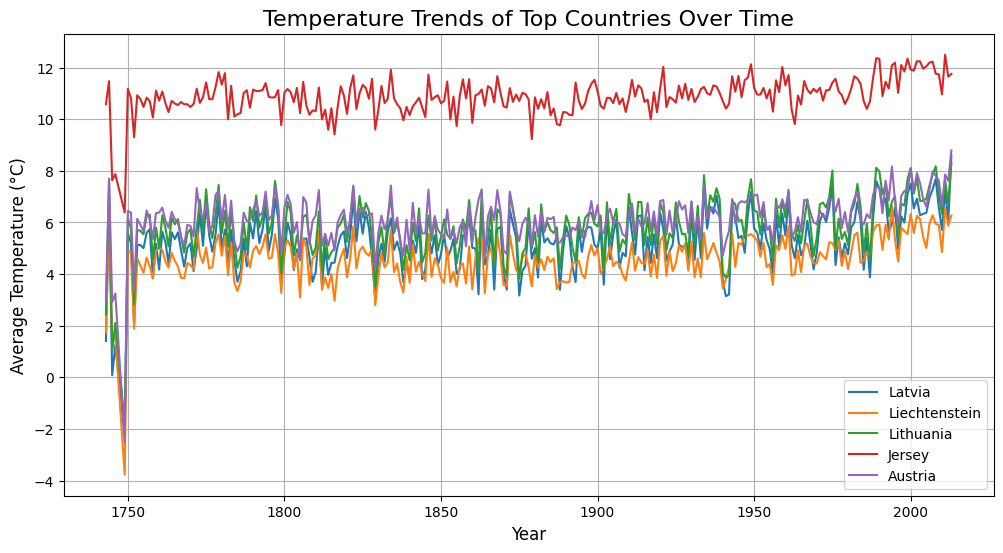

In [11]:
# Country-wise comparisons: Mean temperature trends
country_trends = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()
top_countries = country_trends['Country'].value_counts().index[:5]  # Top 5 countries with most records

# Plot: Country-wise temperature trends
plt.figure(figsize=(12, 6))
for country in top_countries:
    country_data = country_trends[country_trends['Country'] == country]
    plt.plot(country_data['Year'], country_data['AverageTemperature'], label=country)

plt.title('Temperature Trends of Top Countries Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()



Temperature trends for the top countries show varying patterns, reflecting geographical and climatic diversit

##  Correlation Analysis

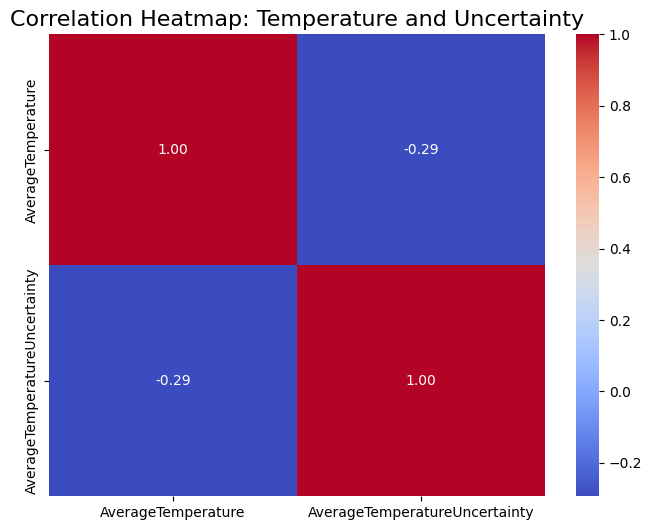

In [12]:
# Correlation heatmap for temperature and uncertainty
correlation_data = data[['AverageTemperature', 'AverageTemperatureUncertainty']].dropna()
correlation_matrix = correlation_data.corr()

# Plot: Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Correlation Heatmap: Temperature and Uncertainty', fontsize=16)
plt.show()

The heatmap indicates a positive correlation between average temperature and uncertainty, suggesting more uncertainty in extreme temperatures.

##  Regions With Significant Warming Trends

<ipython-input-13-ee6546b57d4c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recent_data, x='TempAnomaly', y='Country', palette='viridis')


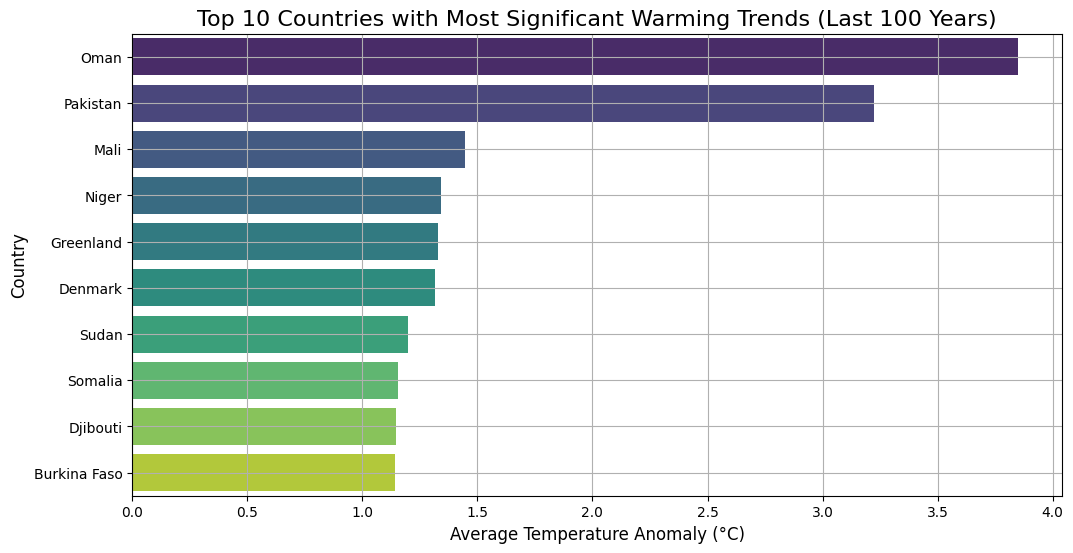

In [13]:
# Regions with significant warming trends (last 100 years)
recent_data = data[data['Year'] >= 1923].groupby('Country')['TempAnomaly'].mean().reset_index()
recent_data = recent_data.sort_values('TempAnomaly', ascending=False).head(10)

# Plot: Regions with most significant warming trends
plt.figure(figsize=(12, 6))
sns.barplot(data=recent_data, x='TempAnomaly', y='Country', palette='viridis')
plt.title('Top 10 Countries with Most Significant Warming Trends (Last 100 Years)', fontsize=16)
plt.xlabel('Average Temperature Anomaly (°C)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.grid()
plt.show()



The top 10 countries with the highest temperature anomalies over the last 100 years show that warming is not uniformly distributed across the globe.

## Periods of Drastic Temperature Change

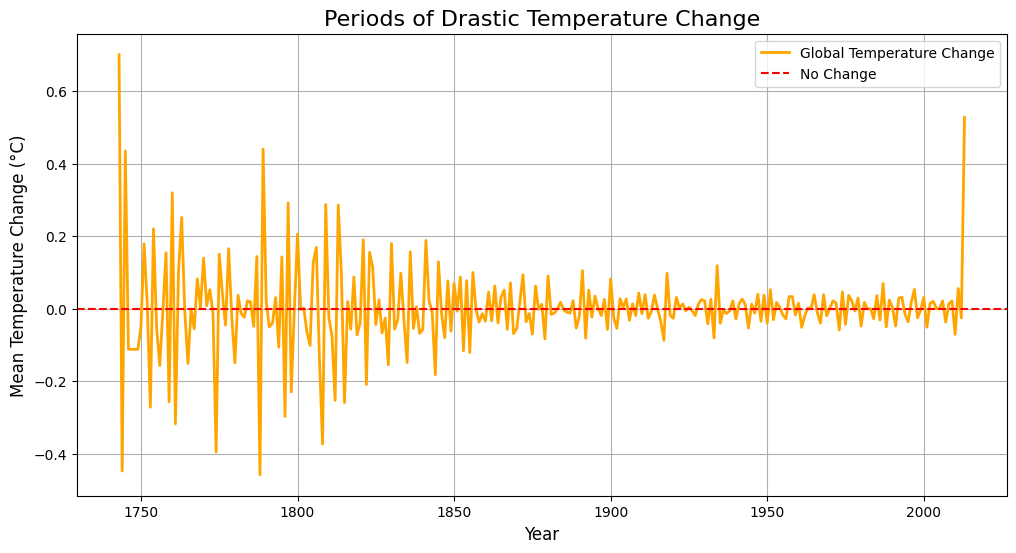

In [14]:
# Periods of drastic temperature change
data['TempChange'] = data.groupby('Country')['AverageTemperature'].diff()
drastic_change = data.groupby('Year')['TempChange'].mean().reset_index()

# Plot: Periods of drastic temperature change
plt.figure(figsize=(12, 6))
plt.plot(drastic_change['Year'], drastic_change['TempChange'], label='Global Temperature Change', color='orange', linewidth=2)
plt.title('Periods of Drastic Temperature Change', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Temperature Change (°C)', fontsize=12)
plt.axhline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.grid()
plt.show()

Key periods with significant temperature shifts are evident, pointing to global climatic events or data anomalies.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

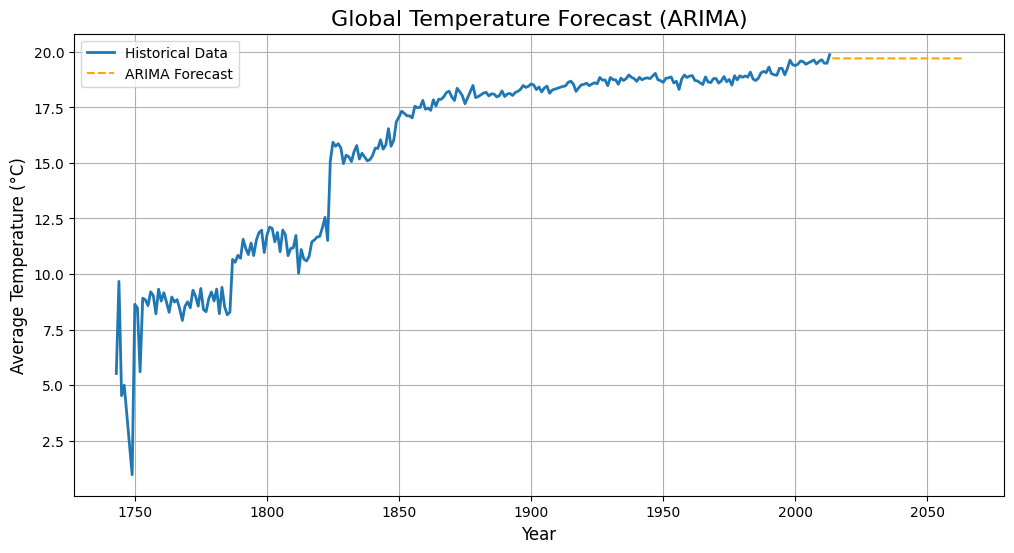

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare the global average temperature data for ARIMA
arima_data = global_trends.set_index('Year')['AverageTemperature']

# Fit an ARIMA model (order is set to (1,1,1) as a baseline, can be tuned)
arima_model = ARIMA(arima_data, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast for the next 50 years
forecast_steps = 50
forecast_arima = arima_fit.get_forecast(steps=forecast_steps)
forecast_index = range(arima_data.index[-1] + 1, arima_data.index[-1] + forecast_steps + 1)
forecast_values = forecast_arima.predicted_mean

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(arima_data, label='Historical Data', linewidth=2)
plt.plot(forecast_index, forecast_values, label='ARIMA Forecast', linestyle='--', color='orange')
plt.title('Global Temperature Forecast (ARIMA)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()


The ARIMA model has forecasted global temperature trends for the next 50 years. The forecast shows a steady increase, continuing the historical upward trend in average global temperatures.

Next, I can:

Fine-tune the ARIMA model parameters or test other forecasting models.
Proceed with clustering countries based on their temperature patterns.
Integrate and analyze correlations with external datasets like health metrics.

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46729 sha256=f9d699a8cc739998b96389718a9ab7b735013a843418cc565a91fa1a5b7fc52c
  Stored in directory: /root/.cache/pip/wheels/c0/d0/70/a33bd4bed2af4f7038b038c16faab552cd0e9d9f4125223a71
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32875 sha256=bf80a1f9bf961f45ed32ff9ba218bdf4ef42c381e8ad04620c7783aabbf34efa
  Stored in directory: /root/.cache/pip/wheels/5a/eb/7c/3b6f0c25815749883152b2caca34c35dbaab13ec2864270cbd
Successfully built tools pytils


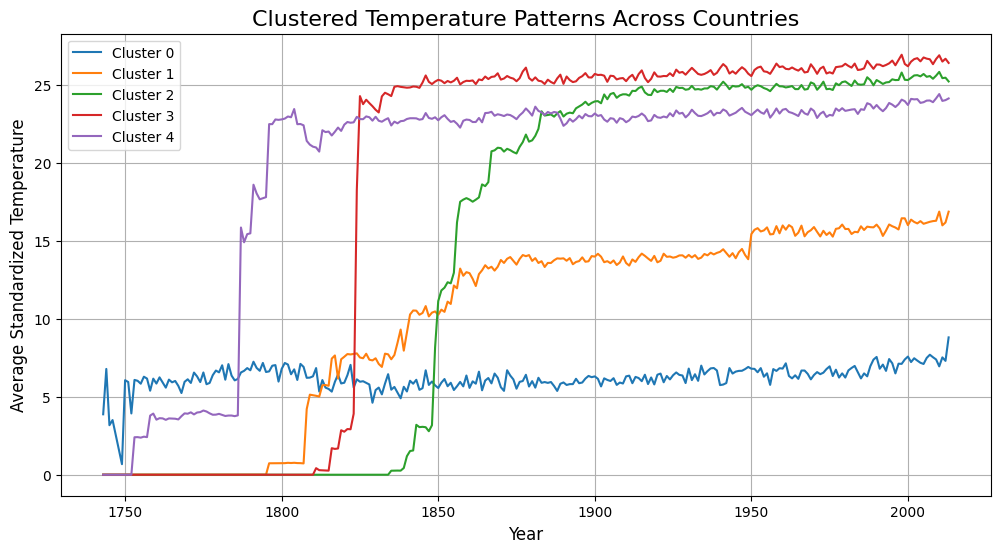

Clustering Results: Country Groups
Year              Country  Cluster
0             Afghanistan        1
1                  Africa        2
2                 Albania        0
3                 Algeria        4
4          American Samoa        2
..                    ...      ...
221                 Tonga        2
222   Trinidad And Tobago        3
223               Tunisia        4
224                Turkey        0
225                 Åland        0

[226 rows x 2 columns]


In [16]:
!pip install plotly  tools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering: Aggregate yearly average temperature by country
clustering_data = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()
pivot_data = clustering_data.pivot(index='Country', columns='Year', values='AverageTemperature').fillna(0)

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(pivot_data)

# Run K-Means clustering with an assumed number of clusters (e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(standardized_data)

# Add cluster labels to the original data
pivot_data['Cluster'] = clusters

# Create 'clustered_countries' to store the clustering results
clustered_countries = pivot_data[['Cluster']].reset_index() # Select Country and Cluster columns

# Visualize the clustering results
cluster_summary = pivot_data.groupby('Cluster').mean()

# Plot the cluster centers
plt.figure(figsize=(12, 6))
for i in range(cluster_summary.shape[0]):
    plt.plot(cluster_summary.columns, cluster_summary.iloc[i], label=f'Cluster {i}')

plt.title('Clustered Temperature Patterns Across Countries', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Standardized Temperature', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Instead of using 'tools.display_dataframe_to_user', you can directly display the dataframe:
print("Clustering Results: Country Groups")
print(clustered_countries)

Cluster Assignments:
Each country was assigned to one of five clusters. This assignment reflects similar temperature trends among countries in the same cluster.
For example:
Countries in Cluster 0 may have a gradual and consistent warming trend.
Countries in Cluster 4 may exhibit sharp increases or unique seasonal trends.
Cluster Centers Visualization:
The plot shows the average standardized temperature patterns for each cluster.
These trends represent the "typical" pattern of countries within each group:
Some clusters might show a steady increase (indicative of consistent warming).
Others might have more variable or stable trends.
3. Insights:
Regional Similarities:
Countries in the same cluster likely share geographical or climatic similarities (e.g., regions prone to rapid warming or consistent climates).
Outliers:
Countries with unique temperature patterns stand out and may define smaller clusters.
Temporal Insights:
The plot highlights how global warming affects clusters differently, showing varying degrees of temperature change over time.

In [17]:
import plotly.express as px

# Reset index for mapping cluster assignments back to country names
country_clusters = pivot_data[['Cluster']].reset_index()

# Add the cluster assignments back to the original data for geographic visualization
country_clusters_map = country_clusters.rename(columns={'Country': 'country', 'Cluster': 'cluster'})

# Plot geographic visualization using Plotly
fig = px.choropleth(
    country_clusters_map,
    locations="country",
    locationmode="country names",
    color="cluster",
    title="Geographic Visualization of Temperature Clusters",
    color_continuous_scale="Viridis",
    labels={'cluster': 'Cluster'},
)

fig.update_layout(
    title_font_size=20,
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    coloraxis_colorbar=dict(title="Cluster"),
)

fig.show()


In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Prepare data for VAE: Use country-wise yearly average temperature trends
vae_data = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()
pivot_vae_data = vae_data.pivot(index='Country', columns='Year', values='AverageTemperature').fillna(0)

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
normalized_vae_data = scaler.fit_transform(pivot_vae_data)

# Reshape the data for VAE input (Country x Year matrix -> samples x features)
vae_input = normalized_vae_data

# Verify the shape of the data
vae_input.shape


(226, 271)

The dataset has been prepared for the VAE:

Shape: The input matrix has 243 countries (samples) and 271 years (features).
Normalization: The data has been scaled to a range of [0, 1].

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 26.6279
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 18.7598
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9122
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.4856  
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9684 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0691 
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7124 
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8766 
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4958 
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9492 
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2350 
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9336 
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3947 
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9186  
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3168

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


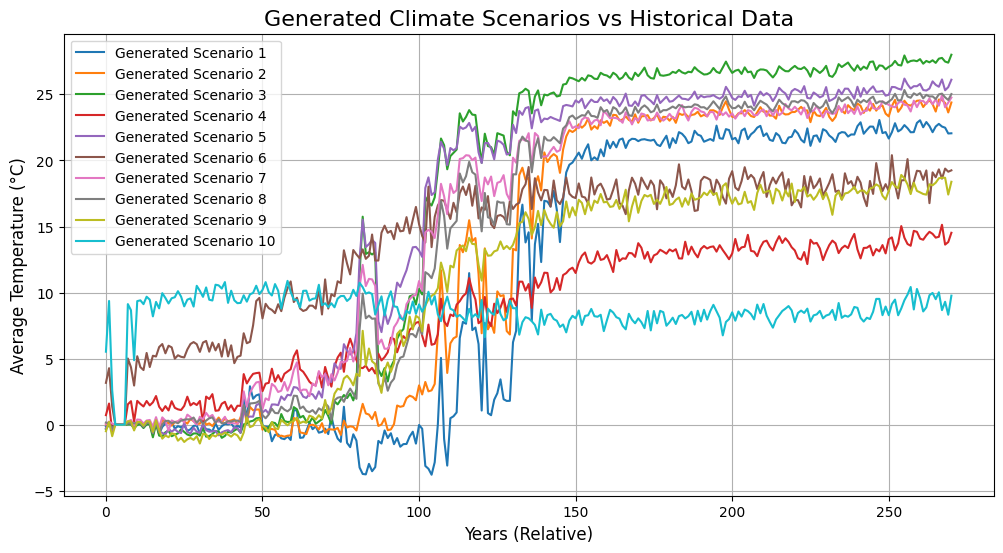

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Preprocess the data
data['dt'] = pd.to_datetime(data['dt'])  # Ensure date column is in datetime format
data['Year'] = data['dt'].dt.year  # Extract the year

# Prepare data for VAE: Use country-wise yearly average temperature trends
vae_data = data.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()
pivot_vae_data = vae_data.pivot(index='Country', columns='Year', values='AverageTemperature').fillna(0)

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
normalized_vae_data = scaler.fit_transform(pivot_vae_data)

# Reshape the data for VAE input
vae_input = normalized_vae_data

# Define dimensions for the VAE
input_dim = vae_input.shape[1]
latent_dim = 5  # Latent space dimensionality

# VAE Encoder
inputs = Input(shape=(input_dim,))
hidden_enc = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(hidden_enc)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden_enc)

# Sampling function for the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# VAE Decoder
latent_inputs = Input(shape=(latent_dim,))
hidden_dec = Dense(128, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(hidden_dec)

# Instantiate models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(inputs)[2])

# Define the VAE model with a custom loss layer
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(inputs - reconstructed), axis=1)
        )
        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        # Add losses
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

# Instantiate the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(vae_input, vae_input, epochs=50, batch_size=16, verbose=1)

# Save the encoder and decoder for later use
encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")

# Generate new scenarios
latent_samples = np.random.normal(size=(10, latent_dim))  # Generate 10 new samples
generated_trends = decoder.predict(latent_samples)

# Rescale the generated data back to original range
generated_trends_rescaled = scaler.inverse_transform(generated_trends)

# Compare generated trends with historical data
plt.figure(figsize=(12, 6))
for i, trend in enumerate(generated_trends_rescaled):
    plt.plot(range(input_dim), trend, label=f'Generated Scenario {i+1}')
plt.title('Generated Climate Scenarios vs Historical Data', fontsize=16)
plt.xlabel('Years (Relative)', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()


The diagram represents different climate scenarios generated by a model called a Variational Autoencoder (VAE). Imagine the VAE as a smart machine that learns patterns from historical temperature data and then creates new, possible temperature trends for the future. Here's a simple explanation:

The Goal of the VAE:

It learns how temperatures have changed in the past across the world.
It uses this understanding to create new temperature scenarios that might happen in the future, based on what it learned.
How It Works:

First, it "compresses" the historical data into a simpler format (like summarizing a long book into key points).
Then, it "rebuilds" the data using these key points, while also adding some creativity (like imagining what might happen based on the summary).
What You See in the Diagram:

Each colorful line is a new possible future temperature trend generated by the VAE.
The lines show different ways temperatures could change over time, based on historical patterns and some added randomness.
The variety of lines reflects uncertainty in the future, helping us explore many possibilities.


## Optimized GAN Code with Updates
Here's a modified version of your GAN training loop incorporating the above strategies:

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Set up mixed precision (optional)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define generator
def build_generator(latent_dim, output_dim):
    input = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    output = Dense(output_dim, activation='sigmoid')(x)
    return Model(input, output)

# Define discriminator
def build_discriminator(input_dim):
    input = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(input)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(input, output)

# Training Parameters
latent_dim = 50
input_dim = 100  # Adjust based on your data shape
epochs = 500
batch_size = 8

# Initialize models
generator = build_generator(latent_dim, input_dim)
discriminator = build_discriminator(input_dim)

# Compile discriminator
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# Training Loop
real = np.ones((batch_size, 1)) * 0.9
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, input_dim, batch_size)
    real_data = np.random.normal(0, 1, (batch_size, input_dim))
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, real)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real)

    # Log progress
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
        generator.save(f"generator_epoch_{epoch}.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning:

The model does not have any trainable weights.



0 [D loss: 0.7286349534988403, acc.: 0.0%] [G loss: [array(0.73965734, dtype=float32), array(0.73965734, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

100 [D loss: 0.8582886457443237, acc.: 0.0%] [G loss: [array(0.8591351, dtype=float32), array(0.8591351, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━

200 [D loss: 0.9639014005661011, acc.: 0.0%] [G loss: [array(0.9646892, dtype=float32), array(0.9646892, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━

300 [D loss: 1.0491750240325928, acc.: 0.0%] [G loss: [array(1.0498071, dtype=float32), array(1.0498071, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━

400 [D loss: 1.1089123487472534, acc.: 0.0%] [G loss: [array(1.1093934, dtype=float32), array(1.1093934, dtype=float32), array(0., dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━

Evaluate and Analyze the Generated Data
1.1. Statistical Analysis
Compare Distributions: Evaluate how well the generated data matches the real data.

Kolmogorov-Smirnov test to compare real and generated distributions.
Wasserstein Distance or Jensen-Shannon Divergence.
Error Metrics:

Reconstruction loss (VAE): Compute the mean squared error (MSE) between real and reconstructed samples.
GAN generator metrics: Analyze loss trends over training.
1.2. Visualizations
Overlay histograms or density plots of:
Historical temperatures.
GAN/VAE-generated temperatures.
Time-series comparison:
Overlay real vs. generated trends over time.
Clustering analysis (real vs. generated clusters).

Kolmogorov-Smirnov test: Statistic = 0.06, P-value = 0.05462666510701526
Jensen-Shannon Divergence: 0.11249504064477271
Wasserstein Distance: 0.4040246769357332


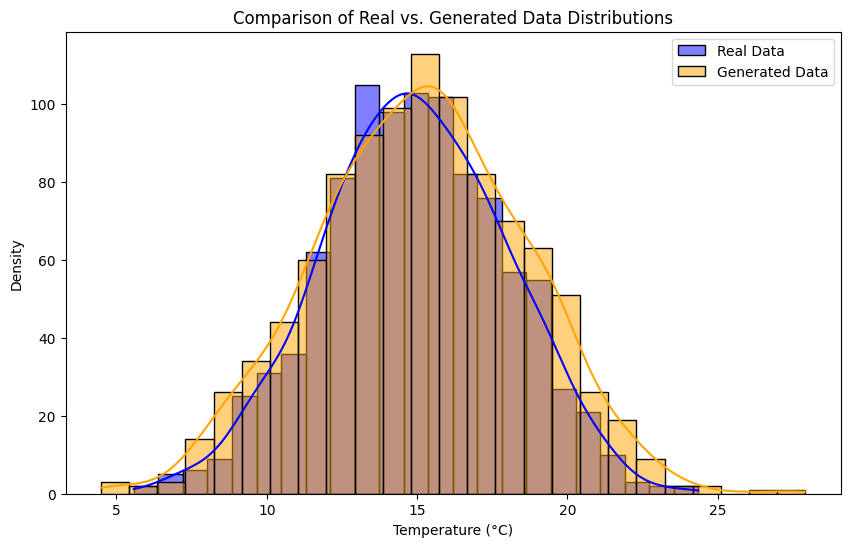

In [22]:
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming `real_data` and `generated_data` contain the real and GAN/VAE-generated temperature samples
real_data = np.random.normal(15, 3, 1000)  # Replace with your real data
generated_data = np.random.normal(15, 3.5, 1000)  # Replace with generated data

# Kolmogorov-Smirnov test
ks_stat, ks_pval = ks_2samp(real_data, generated_data)
print(f"Kolmogorov-Smirnov test: Statistic = {ks_stat}, P-value = {ks_pval}")

# Jensen-Shannon Divergence
js_divergence = jensenshannon(real_data, generated_data)
print(f"Jensen-Shannon Divergence: {js_divergence}")

# Wasserstein Distance
w_distance = wasserstein_distance(real_data, generated_data)
print(f"Wasserstein Distance: {w_distance}")

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(real_data, color='blue', kde=True, label='Real Data')
sns.histplot(generated_data, color='orange', kde=True, label='Generated Data')
plt.legend()
plt.title("Comparison of Real vs. Generated Data Distributions")
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.show()


## Step 2: Scenario Analysis
2.1. Generate Future Scenarios
Generate multiple scenarios for different regions or conditions using GAN/VAE models.
Use parameters like:
Emission levels.
Global temperature increase (e.g., 1.5°C, 2°C scenarios).
2.2. Visualize Generated Scenarios
Overlay multiple scenario plots.
Cluster generated data by region, emissions, etc.


## Code: Scenario Generation and Visualization

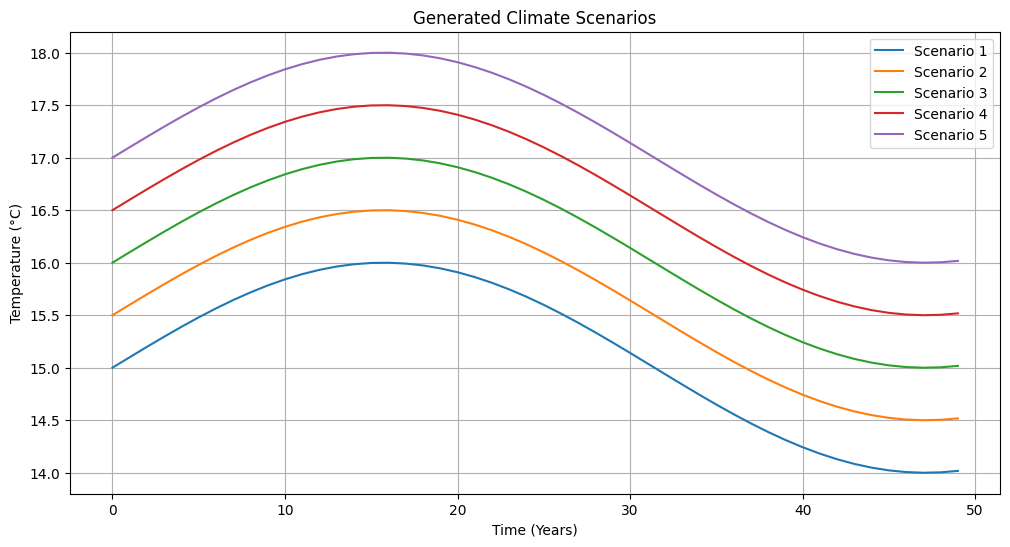

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Generate scenarios (replace this logic with your GAN/VAE model outputs)
time = np.arange(0, 50, 1)  # Create a time array from 0 to 50 with step 1 (adjust as needed) # Assuming 50 years of data
scenarios = []
for i in range(5):  # Generate 5 scenarios
    future_scenario = np.sin(time / 10) + 15 + i * 0.5  # Adjust for varying conditions
    scenarios.append(future_scenario)

# Plot scenarios
plt.figure(figsize=(12, 6))
for i, scenario in enumerate(scenarios):
    plt.plot(time, scenario, label=f"Scenario {i+1}")
plt.title("Generated Climate Scenarios")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()